In [47]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import plotly.express as px
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [48]:
# load the `train32.csv` file
path_to_data = "C:\\Users\\Marko\\Downloads\\archive\\"
train_df32 = pd.read_csv(path_to_data + "train32.csv")

def convert_indication_type(row):
    if row != "good":
        return "damaged"
    else:
        return "good"

def convert_indication_value(row):
    if row != 0:
        return 1
    else:
        return 0

train_df32["indication_type"] = train_df32["indication_type"].apply(convert_indication_type)
train_df32["indication_value"] = train_df32["indication_value"].apply(convert_indication_value)
train_df32.head()

,index,angle,indication_type,indication_value,split
0,48000,40,good,0,train
1,48001,60,good,0,train
2,48002,20,good,0,train
3,48003,40,good,0,train
4,48004,20,good,0,train


In [49]:
train_df32.indication_type.value_counts(normalize=True).round(2)

indication_type
damaged    0.83
good       0.17
Name: proportion, dtype: float64

In [ ]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/good/{i}.jpeg"
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          
        plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [51]:
# generate train data
train_gen = H5ToStorage(path_to_data + "matchingtDATASET_train_32.h5", "train")
train_dict = train_gen.to_storage()

In [52]:

# generate test data
test_gen = H5ToStorage(path_to_data + "matchingtDATASET_test_32.h5", "test")
test_dict = test_gen.to_storage()

In [53]:

# train data & test data paths
test_dir = "dataset/test"
train_dir = "dataset/train"

In [ ]:
# create train data pipeline
IMG_SIZE = (32, 32)
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         validation_split=0.2,   # 20 % Validation
                                                         subset="training",
                                                         seed=123,
                                                         color_mode="grayscale",
                                                         label_mode="int",
                                                         batch_size=32)
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()


val_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=32
)

val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=32,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

Found 72000 files belonging to 2 classes.
Using 57600 files for training.
The class_names are as follows: ['damaged', 'good']
Found 72000 files belonging to 2 classes.
Using 14400 files for validation.
Found 36000 files belonging to 2 classes.


In [55]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(32, 32, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
  ])




c:\Users\Marko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [57]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,625 (604.00 KB)

 Trainable params: 154,625 (604.00 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
epochs=10
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 199s 109ms/step - accuracy: 0.8503 - loss: 0.3515 - val_accuracy: 0.8844 - val_loss: 0.2676
Epoch 2/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9020 - loss: 0.2242 - val_accuracy: 0.9428 - val_loss: 0.1501
Epoch 3/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9645 - loss: 0.0959 - val_accuracy: 0.9867 - val_loss: 0.0472
Epoch 4/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9898 - loss: 0.0322 - val_accuracy: 0.9981 - val_loss: 0.0111
Epoch 5/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 6/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.8455e-04
Epoch 7/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 1.0000 - loss: 8.6351e-05 - val_accuracy: 1.0000 - val_loss: 6.3082e-05
Epoch 8/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accu

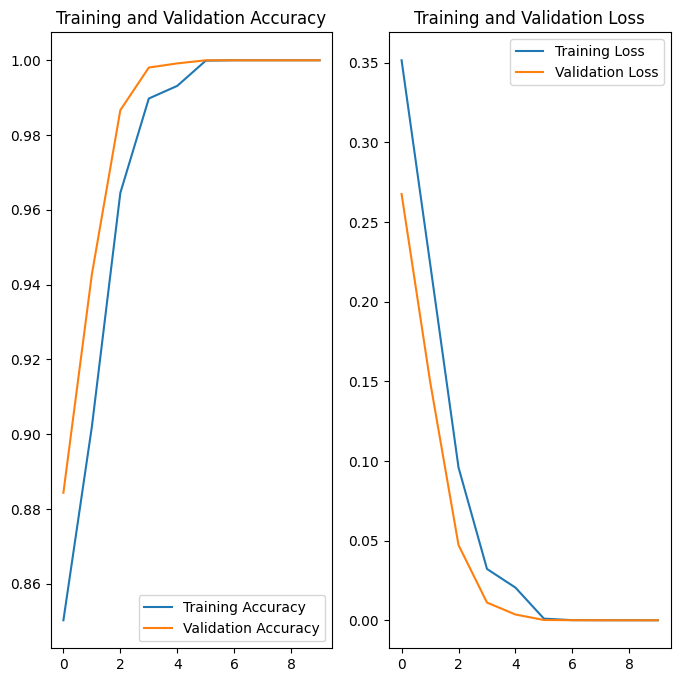

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# y_true from test_data
y_true = np.concatenate([y.numpy() for _, y in test_data])

# predict
y_prob = model.predict(test_data).ravel()     
y_pred = (y_prob >= 0.5).astype(int)

print("F1 (binary):", f1_score(y_true, y_pred, average='binary'))
print(classification_report(y_true, y_pred, target_names=class_names))

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
F1 (binary): 0.47505270555165147
              precision    recall  f1-score   support

     damaged       0.89      0.91      0.90     30000
        good       0.50      0.45      0.48      6000

    accuracy                           0.83     36000
   macro avg       0.70      0.68      0.69     36000
weighted avg       0.83      0.83      0.83     36000

